In [2]:
import numpy as np
import math
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.special import factorial
from collections import Counter

## Task 1: Erlang system

In [197]:
def unnormalized_truncated_poisson(i, mean_arrival = 1, mean_service = 8):
    A = mean_arrival * mean_service
    return A**i/math.factorial(i)

def MetropolisHastings_RW(initial_state, num_samples, max_state, mean_arrival=1, mean_service=8):
    samples = []
    curr_state = initial_state

    for _ in range(num_samples):
        # propose a small step delta (like in slides)
        delta = np.random.choice([-2,-1,1,2])
        proposal = curr_state + delta

        # handle out of bounds
        if proposal < 0 or proposal > max_state:
            samples.append(curr_state)
            continue

        p_curr = unnormalized_truncated_poisson(curr_state, mean_arrival, mean_service)
        p_prop = unnormalized_truncated_poisson(proposal, mean_arrival, mean_service)

        acceptance_ratio = min(1, p_prop / p_curr)

        if np.random.uniform(0, 1) < acceptance_ratio:
            curr_state = proposal

        samples.append(curr_state)

    return samples

In [199]:
samples = MetropolisHastings_RW(7, 1_000_000, 10)
samples = samples[500_000:] # discard warm-up samples

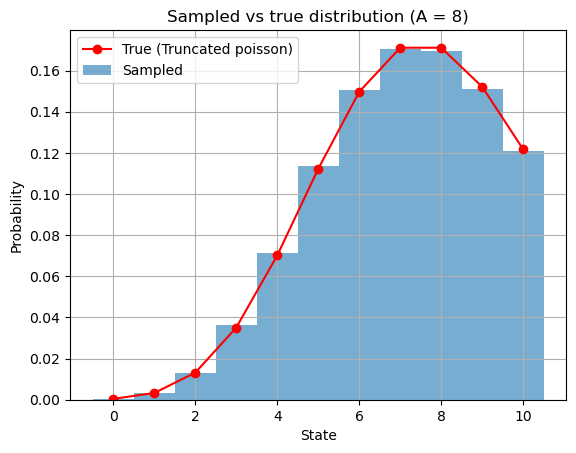

In [177]:
def plot_histogram(samples, A, max_state):
    plt.hist(samples, bins=np.arange(max_state + 2) - 0.5, density=True, alpha=0.6, label="Sampled")

    # overlay the true Poisson PMF (truncated and normalized)
    x = np.arange(0, max_state + 1)
    true_probs = poisson.pmf(x, mu=A)
    true_probs /= true_probs.sum()  # normalize over truncated range

    plt.plot(x, true_probs, 'o-', color='red', label='True (Truncated poisson)')
    plt.xlabel("State")
    plt.ylabel("Probability")
    plt.title(f"Sampled vs true distribution (A = {A})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histogram(samples, A=8, max_state=10)


Verify with $\chi^2$ test

In [178]:
def chi2_test(samples, mean_arrival=1, mean_service=8, max_state=10):
    counts = np.bincount(samples, minlength=max_state+1)
    expected_unnorm = np.array([unnormalized_truncated_poisson(i, mean_arrival, mean_service) for i in range(max_state+1)])
    expected_probs = expected_unnorm / expected_unnorm.sum()
    expected_counts = expected_probs * len(samples)

    stat, p = chisquare(f_obs=counts, f_exp=expected_counts)
    return stat, p

In [200]:
stat, p = chi2_test(samples, 1, 8, max_state=10)
print(f"Chi-squared stat: {stat:.2f}, p-value: {p:.4f}")

Chi-squared stat: 9.65, p-value: 0.4719


## Task 2: Two call types

In [201]:
def two_unnormalized_truncated_poisson(i,j, A1=4, A2=4):
    return A1**i/math.factorial(i) * A2**j/math.factorial(j)

### Joint

In [215]:
def TwoMetropolisHastings_joint_RW(initial_state1, initial_state2, num_samples, max_state, A1=4, A2=4):
    samples = []
    curr_i = initial_state1
    curr_j = initial_state2

    # define deltas
    deltas = [(di, dj) for di in [-2, -1, 0, 1, 2] 
                    for dj in [-2, -1, 0, 1, 2] 
                    if not (di == 0 and dj == 0)]

    for _ in range(num_samples):
        delta_i, delta_j = deltas[np.random.randint(len(deltas))]
        proposal_i = curr_i + delta_i
        proposal_j = curr_j + delta_j

        if proposal_i < 0 or proposal_j < 0 or (proposal_i + proposal_j > max_state):
            samples.append((curr_i, curr_j))
            continue

        p_curr = two_unnormalized_truncated_poisson(curr_i, curr_j, A1, A2)
        p_prop = two_unnormalized_truncated_poisson(proposal_i, proposal_j, A1, A2)
        acceptance_ratio = min(1, p_prop / p_curr)

        if np.random.uniform(0, 1) < acceptance_ratio:
            curr_i, curr_j = proposal_i, proposal_j

        samples.append((curr_i, curr_j))

    return samples

In [223]:
samples_joint_metropolis = TwoMetropolisHastings_joint_RW(4,4, 1_000_000, 10)
samples_joint_metropolis = samples_joint_metropolis[500_000:] # discard warm-up samples

### Coordinate wise

In [207]:
def TwoMetropolisHastings_coord_RW(initial_state1, initial_state2, num_samples, max_state, A1=4, A2=4):
    samples = []
    curr_i = initial_state1
    curr_j = initial_state2

    for _ in range(num_samples):
        # update coordinate 1 
        delta_i = np.random.choice([-2,-1, 1,2])
        proposal_i = curr_i + delta_i

        if 0 <= proposal_i <= max_state and proposal_i + curr_j <= max_state:
            p_curr = two_unnormalized_truncated_poisson(curr_i, curr_j, A1, A2)
            p_prop = two_unnormalized_truncated_poisson(proposal_i, curr_j, A1, A2)
            accept_ratio = min(1, p_prop / p_curr)

            if np.random.uniform() < accept_ratio:
                curr_i = proposal_i

        # update coordinate 2 
        delta_j = np.random.choice([-2,-1, 1,2])
        proposal_j = curr_j + delta_j

        if 0 <= proposal_j <= max_state and curr_i + proposal_j <= max_state:
            p_curr = two_unnormalized_truncated_poisson(curr_i, curr_j, A1, A2)
            p_prop = two_unnormalized_truncated_poisson(curr_i, proposal_j, A1, A2)
            accept_ratio = min(1, p_prop / p_curr)

            if np.random.uniform() < accept_ratio:
                curr_j = proposal_j

        samples.append((curr_i, curr_j))

    return samples


In [217]:
samples_coordinate_metropolis = TwoMetropolisHastings_coord_RW(4,4, 1_000_000, 10)
samples_coordinate_metropolis = samples_coordinate_metropolis[500_000:] # discard warm-up samples

### Gibbs

In [135]:
def GibbsSampling(initial_state, num_samples, max_state, A1 = 4, A2 = 4):
    samples = []
    i,j = initial_state, initial_state

    for i in range(num_samples):
        i_max = max_state - j 
        i_vals = np.arange(i_max + 1)
        probs_i = (A1**i_vals) / factorial(np.arange(max_state+1))[i_vals]
        probs_i /= probs_i.sum()
        i = np.random.choice(i_vals, p=probs_i)

        j_max = max_state - i
        j_vals = np.arange(j_max + 1)
        probs_j = (A2**j_vals) / factorial(np.arange(max_state+1))[j_vals]
        probs_j /= probs_j.sum()
        j = np.random.choice(j_vals, p=probs_j)

        samples.append((i,j))
    return samples

In [136]:
samples_gibbs = GibbsSampling(0, 800_000, 10)
samples_gibbs = samples_gibbs[400000:] # discard warm-up samples

$\chi^2$ test

In [205]:
def chi2_test(samples, max_state, A1=4, A2=4):
    # count occurrences
    counts = Counter(samples)
    observed = np.zeros((max_state + 1, max_state + 1))
    for (i, j), count in counts.items():
        observed[i, j] = count

    # normalizing constant
    Z = sum(two_unnormalized_truncated_poisson(i, j)
            for i in range(max_state + 1)
            for j in range(max_state + 1)
            if i + j <= max_state)

    # expected frequencies
    expected = np.zeros((max_state + 1, max_state + 1))
    for i in range(max_state + 1):
        for j in range(max_state + 1):
            if i + j <= max_state:
                prob = two_unnormalized_truncated_poisson(i, j) / Z
                expected[i, j] = prob * len(samples)

    obs_flat = observed.flatten()
    exp_flat = expected.flatten()

    mask = exp_flat > 0

    # Chi-squared test
    chi2_stat, p_value = chisquare(f_obs=obs_flat[mask], f_exp=exp_flat[mask])

    print(f"Chi-squared statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    return chi2_stat, p_value

In [224]:
chi2_test(samples_coordinate_metropolis, 10)
chi2_test(samples_joint_metropolis, 10)
chi2_test(samples_gibbs, 10)

Chi-squared statistic: 132.6450
p-value: 0.0000
Chi-squared statistic: 222.9314
p-value: 0.0000
Chi-squared statistic: 71.9503
p-value: 0.2588


(71.95025782308606, 0.258776000910787)

In [213]:
def plot_joint_distribution_residual(samples, max_state, A1=4, A2=4):
    counts = Counter(samples)
    empirical_freq = np.zeros((max_state+1, max_state+1))
    for (i, j), count in counts.items():
        empirical_freq[i, j] = count
    empirical_prob = empirical_freq / np.sum(empirical_freq)

    # theoretical distribution
    theoretical_unnorm = np.zeros((max_state+1, max_state+1))
    for i in range(max_state+1):
        for j in range(max_state+1 - i):
            theoretical_unnorm[i, j] = (A1**i) / math.factorial(i) * (A2**j) / math.factorial(j)
    Z = np.sum(theoretical_unnorm)
    theoretical_prob = theoretical_unnorm / Z

    # compute residuals (empirical - theoretical)
    residuals = empirical_prob - theoretical_prob

    # plot residual heatmap
    plt.figure(figsize=(7,6))
    im = plt.imshow(residuals, origin='lower', cmap='bwr', vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)))
    plt.colorbar(im, label='Residual (Empirical - Theoretical)')
    plt.title('Residuals between empirical and theoretical distributions')
    plt.xlabel('j')
    plt.ylabel('i')
    plt.show()


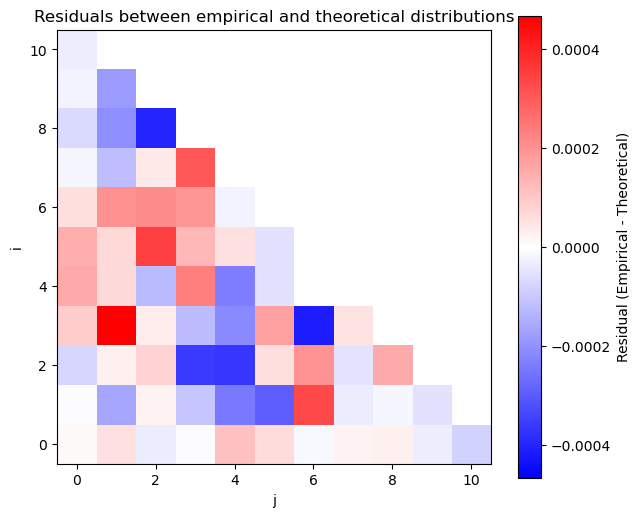

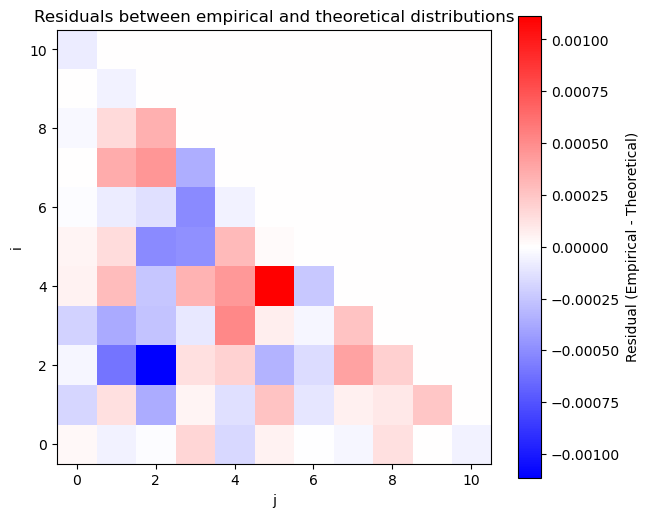

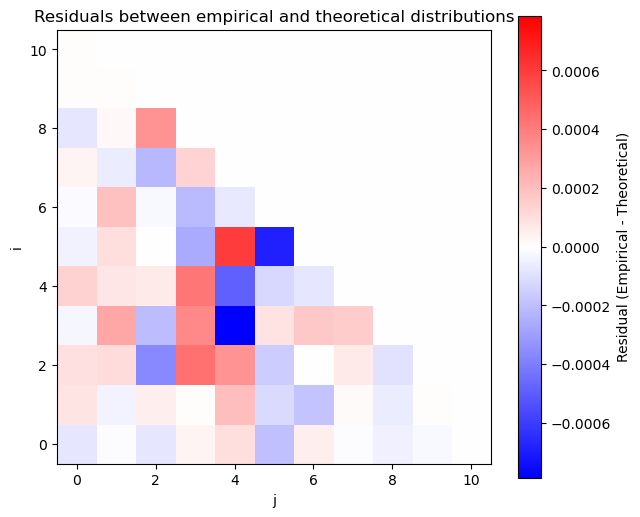

In [219]:
plot_joint_distribution_residual(samples_coordinate_metropolis, 10)
plot_joint_distribution_residual(samples_joint_metropolis, 10)
plot_joint_distribution_residual(samples_gibbs, 10)

## Task 3: Bayesian problem

In [3]:
def sample_from_prior(rho=0.5):
    # with correlation rho
    cov_matrix = np.array([[1, rho], [rho, 1]])
    
    xi_gamma = np.random.multivariate_normal(mean=[0, 0], cov=cov_matrix)
    xi, gamma = xi_gamma

    # transform to (theta, psi)
    theta = np.exp(xi)
    psi = np.exp(gamma)

    return theta, psi

In [14]:
theta, psi = sample_from_prior()
print(f"Theta: {theta}, Psi: {psi}")

Theta: 0.8972348316794688, Psi: 0.4562348243982901


In [25]:
def generate_data(theta, psi, n=10):
    return np.random.normal(loc=theta, scale=np.sqrt(psi), size=n)

X = generate_data(theta, psi, n=10)
print("Generated data:", X)

Generated data: [0.23103989 0.53660028 0.83928611 1.09244506 0.04431525 1.9370516
 1.15830853 0.84223136 1.25191277 0.78707529]


In [ ]:
def posterior_density(theta, psi, X, rho=0.5):
    n = len(X)
    X_bar = np.mean(X)
    S2 = np.var(X, ddof=1)  # sample variance

    # prior density (joint normal on log(theta), log(psi))
    log_theta = np.log(theta)
    log_psi = np.log(psi)
    prior_den = (1 / (2 * np.pi * theta * psi * np.sqrt(1 - rho**2))) * np.exp(-1/(2*(1 - rho**2)) * (log_theta**2 - 2*rho*log_theta*log_psi + log_psi**2))

    # likelihood density (using sample mean and variance)
    likelihood_den = (psi ** (-n/2)) * np.exp(- (n/(2*psi)) * (X_bar - theta)**2) * np.exp(- ((n - 1)/(2*psi)) * S2)

    # posterior proportional to prior * likelihood
    posterior = prior_den * likelihood_den
    return posterior

def metropolis_hastings_posterior(X, initial, num_samples, rho=0.5, proposal_scale=0.1):
    samples = []
    theta_curr, psi_curr = initial

    for _ in range(num_samples):
        # propose new values on log-scale to ensure positivity
        log_theta_prop = np.log(theta_curr) + np.random.normal(0, proposal_scale)
        log_psi_prop = np.log(psi_curr) + np.random.normal(0, proposal_scale)

        theta_prop = np.exp(log_theta_prop)
        psi_prop = np.exp(log_psi_prop)

        # compute posterior densities 
        post_curr = posterior_density(theta_curr, psi_curr, X, rho)
        post_prop = posterior_density(theta_prop, psi_prop, X, rho)

        # acceptance probability 
        accept_ratio = post_prop / post_curr if post_curr > 0 else 1

        if np.random.uniform() < accept_ratio:
            theta_curr, psi_curr = theta_prop, psi_prop  # accept proposal

        samples.append((theta_curr, psi_curr))

    return samples

In [ ]:
initial = (1, 1)
num_samples = 10000

# run Metropolis-Hastings sampler
samples = metropolis_hastings_posterior(X, initial, num_samples)
samples = np.array(samples[5000:])

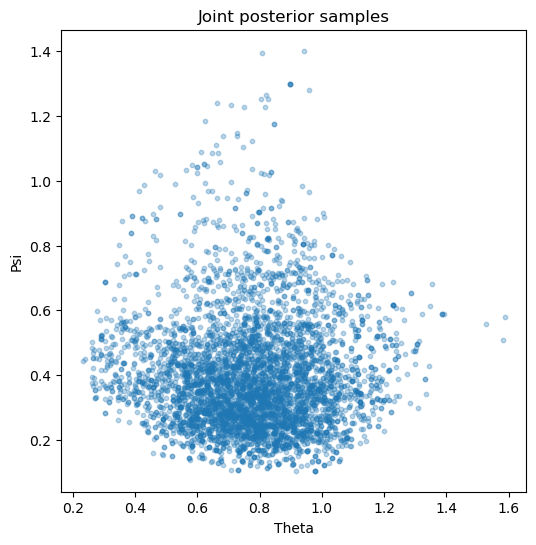

In [27]:
# scatter plot of joint samples
plt.figure(figsize=(6,6))
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, s=10)
plt.xlabel('Theta')
plt.ylabel('Psi')
plt.title('Joint posterior samples')
plt.show()


In [28]:
X = generate_data(theta, psi, n=100)
samples = metropolis_hastings_posterior(X, initial, num_samples)
samples = np.array(samples[5000:])

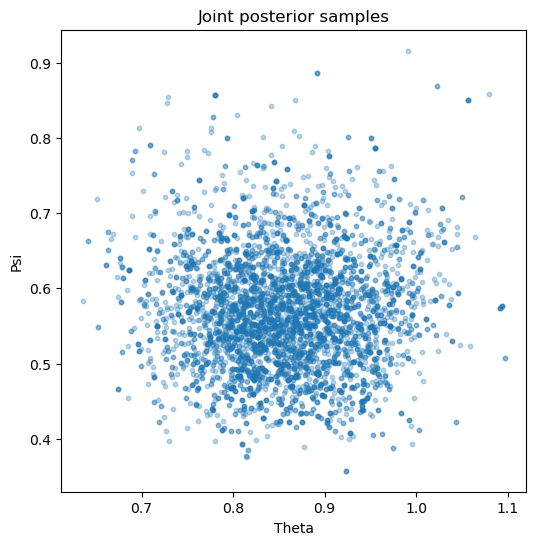

In [29]:
# scatter plot of joint samples
plt.figure(figsize=(6,6))
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, s=10)
plt.xlabel('Theta')
plt.ylabel('Psi')
plt.title('Joint posterior samples')
plt.show()


In [30]:
X = generate_data(theta, psi, n=1000)
samples = metropolis_hastings_posterior(X, initial, num_samples)
samples = np.array(samples[5000:])

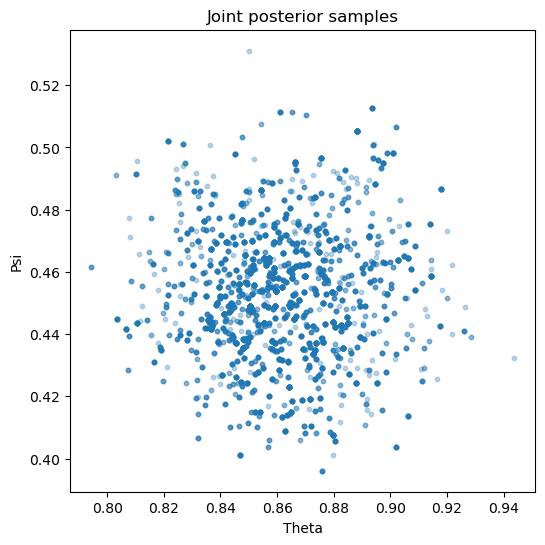

In [31]:
# scatter plot of joint samples
plt.figure(figsize=(6,6))
plt.scatter(samples[:,0], samples[:,1], alpha=0.3, s=10)
plt.xlabel('Theta')
plt.ylabel('Psi')
plt.title('Joint posterior samples')
plt.show()
